In [ ]:
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics
"""
# downloading the images

!wget https://challengedata.ens.fr/media/public/train-images.zip
!wget https://challengedata.ens.fr/media/public/test-images.zip
!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv

!unzip train-images.zip
!unzip test-images.zip

"""






'\n# downloading the images\n\n!wget https://challengedata.ens.fr/media/public/train-images.zip\n!wget https://challengedata.ens.fr/media/public/test-images.zip\n!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv\n\n!unzip train-images.zip\n!unzip test-images.zip\n\n'

In [ ]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

PATH ='/content/drive/MyDrive/Raidium_challenge/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the train labels
# Note the transpose!
labels_train = pd.read_csv(PATH + "y_train.csv", index_col=0).T

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision import models, datasets, transforms
import os
import glob
from PIL import Image


In [ ]:
import re
def alphanumeric_sort(name):
    parts = re.split('(\d+)', name)
    return [int(part) if part.isdigit() else part for part in parts]



In [ ]:
class CTDataset(Dataset):
  def __init__(self,path,transform=None):
    self.filenames = sorted(glob.glob(os.path.join(path, '**/*.png'),recursive = True),key=alphanumeric_sort)
    self.transform = transform
    dataset_list = []
    for image_file in self.filenames:
        dataset_list.append(Image.open(image_file).convert("RGB"))
    self.imgs = np.stack(dataset_list, axis=0)


  def __getitem__(self, index):
    img_path=self.filenames[index]
    #label = self.filenames[index].split("/")[-2]
    img = Image.open(img_path).convert("RGB")
    if self.transform is not None:
      img=self.transform(img)
    return img, img_path


  def __len__(self):
    return len(self.imgs)



In [ ]:
import pandas as pd
seg_choice = pd.read_csv(PATH + "test_predictions_vits.csv")
seg_choice['label']

,label
0,/content/drive/MyDrive/Raidium_challenge/train...
1,/content/drive/MyDrive/Raidium_challenge/train...
2,/content/drive/MyDrive/Raidium_challenge/train...
3,/content/drive/MyDrive/Raidium_challenge/train...
4,/content/drive/MyDrive/Raidium_challenge/train...
...,...
495,/content/drive/MyDrive/Raidium_challenge/train...
496,/content/drive/MyDrive/Raidium_challenge/train...
497,/content/drive/MyDrive/Raidium_challenge/train...
498,/content/drive/MyDrive/Raidium_challenge/train...


In [ ]:
labels_train

,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,...,Pixel 65526,Pixel 65527,Pixel 65528,Pixel 65529,Pixel 65530,Pixel 65531,Pixel 65532,Pixel 65533,Pixel 65534,Pixel 65535
0.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Extraction de l'ID du fichier
seg_choice['label'] = seg_choice['label'].str.extract(r'(\d+)\.png')
for choice in seg_choice['label']:
  print(choice)

1352
1586
1048
1586
645
1586
1048
1850
1586
1142
1510
1142
738
739
1601
1188
1671
308
642
559
1472
1182
1448
659
660
1596
1472
1998
95
1956
1998
401
822
822
1998
1956
344
190
285
52
344
1026
1905
1055
1905
1091
1380
936
650
49
49
1091
1380
650
1909
1549
571
571
1534
571
1534
1909
1549
157
175
288
273
1325
293
418
418
355
125
862
1930
247
247
247
247
247
1550
1658
587
381
1598
1460
1574
1574
1671
794
1423
1516
1423
1693
1423
1108
1649
731
942
510
1739
870
602
510
1155
1155
510
1799
1605
1799
1998
1998
1998
1605
1799
279
1407
1407
1444
1407
1407
1444
1511
1407
438
1336
438
1331
1956
1301
609
1956
1336
166
1709
1709
166
658
293
1356
293
1935
895
780
44
454
44
100
454
1544
781
682
1617
1601
1240
1462
1617
1240
1462
1617
757
775
1301
362
1995
671
95
1958
1451
471
238
1002
1119
1630
412
1118
1078
1039
927
1078
1405
1039
926
1078
632
272
847
848
401
401
332
1091
51
621
1824
391
1342
1895
1453
513
1453
1453
35
491
1229
491
1914
478
1229
491
1229
1928
1950
1582
1928
1928
1155
1744
101
1553
1294

In [ ]:
np.sum(seg_choice['label'].astype(int)>1200)

226

In [ ]:
batch_size = 1
dataset = CTDataset(PATH + "train-images")
dl = DataLoader(dataset, batch_size=batch_size)


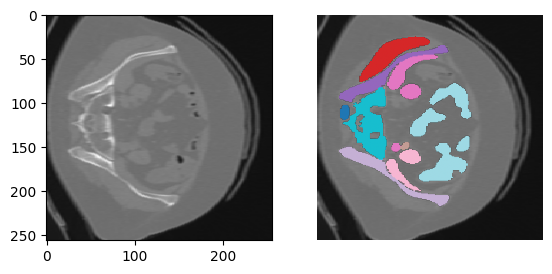

In [ ]:
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256, 256)) == 0, (seg.reshape((256, 256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

plot_slice_seg(dataset.imgs[0], labels_train.iloc[0].values.reshape((256, 256)))

In [ ]:
index_thorax=[304,305,327,331,415,418,114]
index_cuisse =[393,1352,1442,1443,1578,1579,1586,1587,1588,1654,1655,1779,1850]
index_pelvis = [115, 243, 295, 342,279]
index_bizarre = [1648,1649,1653,1652,1711,1712,1849]
index_tete=[1679,1702,1736,1737,1601,1616,99,102,103]
index_abdo3=[69,70]
index_abdo4=[80,81]
index_abdo2=[0,6,75]


index_chepa=[1623,1624,1768,1769,1783,1784,106,107,108,109,110,111]

index_lungs = [106,107,491,511,1066,1070,1071,1185,1229,1230,1277,1285,1286,1287,1288,1484]
index_thorax2=[101,157,175,272,273,288,293,336,418,510,534,602,632,655,691]



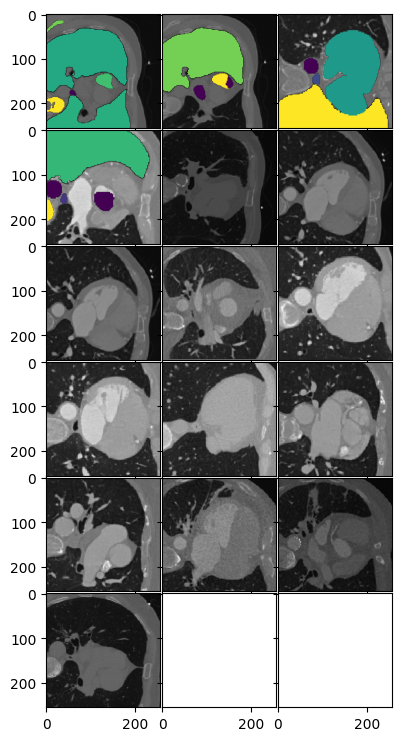

In [ ]:
def visu_index(index_img, index):
  nrows = len(index_img) //3 +1
  fig =plt.figure(figsize=(6,9))
  grid = ImageGrid(fig,111, (nrows,3))
  for ax,im in zip(grid, index_img):
    ax.imshow(dataset.imgs[im], cmap="gray")
    seg_masked = np.ma.masked_where(labels_train.iloc[im].values.reshape((256, 256))== 0, (labels_train.iloc[im].values.reshape((256, 256))))
    ax.imshow(seg_masked)

visu_index(index_lungs,54)

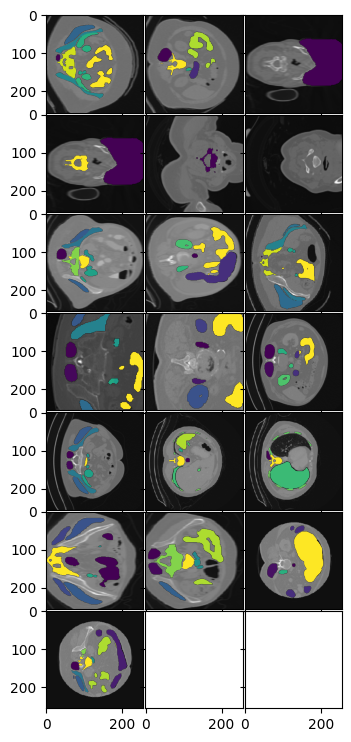

In [ ]:
def visu_label(index_img):
  nrows = len(index_img) //3 +1
  fig =plt.figure(figsize=(6,9))
  grid = ImageGrid(fig,111, (nrows,3))
  for ax,im in zip(grid, index_img):
    ax.imshow(dataset.imgs[im], cmap="gray")
    seg_masked = np.ma.masked_where(labels_train.iloc[im].values.reshape((256, 256)) == 0, (labels_train.iloc[im].values.reshape((256, 256))))
    ax.imshow(seg_masked)

visu_label(np.arange(19))

In [ ]:
#!pip install monai

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


In [ ]:
from monai.networks.nets import UNETR
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, ToTensor
)
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image


In [ ]:

# ---------------------- 1️⃣ Convertir le DataFrame en images ----------------------

# Charger le DataFrame contenant les masques
#labels_train = pd.read_csv(PATH + "y_train.csv", index_col=0).T  # Assurez-vous du `.T`

# Créer un dossier pour sauvegarder les masques
os.makedirs(PATH + "masks/", exist_ok=True)

# Convertir chaque ligne en image 256x256
for index, row in labels_train.iterrows():
    mask_array = row.values.reshape(256, 256).astype(np.uint8)  # Convertir en 0-255
    mask_img = Image.fromarray(mask_array)
    mask_img.save(PATH + f"masks/{index}")  # Sauvegarder avec le même nom (ex: 0.png, 1.png)
# ---------------------- 2️⃣ Charger les images et masques avec MONAI ----------------------


In [ ]:
#labels_train = pd.read_csv(PATH + "y_train.csv", index_col=0).T
class CTScanDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])  # Même nom pour l'image et le masque

        image = Image.open(img_path).convert("L")  # Charger en niveaux de gris
        mask = Image.open(mask_path).convert("L")

        image = np.array(image, dtype=np.float32)
        mask = np.array(mask, dtype=np.uint8)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Définir les transformations MONAI
transform = Compose([ToTensor()])

# Charger les datasets
dataset = CTScanDataset(img_dir=PATH + "train-images/", mask_dir=PATH + "masks/", transform=transform)
#train_set, val_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
#val_loader = DataLoader(val_set, batch_size=10, shuffle=False)



In [ ]:
# ---------------------- 3️⃣ Charger UNetR pré-entraîné ----------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"""
model = UNETR(
    in_channels=1,
    out_channels=1,  # Binaire (1 canal de sortie)
    img_size=(256, 256,1),
    feature_size=16
).to(device)
"""

from monai.networks.nets import UNet

model = UNet(
    spatial_dims=2,  # Indique bien que c'est du 2D
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),  # Profondeurs des features
    strides=(2, 2, 2, 2),  # Strides pour chaque niveau
).to(device)
# ---------------------- 4️⃣ Définir la Loss et l'Optimiseur ----------------------

criterion = DiceLoss(sigmoid=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
metric = DiceMetric(include_background=True, reduction="mean")





In [ ]:
# ---------------------- 5️⃣ Entraîner le modèle ----------------------

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        images=images.unsqueeze(1)
        #images = images.permute(1, 0, 2, 3)  # Passe de [1, 10, 256, 256] à [10, 1, 256, 256]

        outputs = model(images)
        masks = masks.unsqueeze(1)  # Ajoute une dimension pour avoir [10, 1, 256, 256]

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")


100%|██████████| 200/200 [00:35<00:00,  5.62it/s]


Epoch [1/200], Loss: 0.5818


100%|██████████| 200/200 [00:17<00:00, 11.17it/s]


Epoch [2/200], Loss: 0.4818


100%|██████████| 200/200 [00:18<00:00, 11.08it/s]


Epoch [3/200], Loss: 0.4561


100%|██████████| 200/200 [00:18<00:00, 10.83it/s]


Epoch [4/200], Loss: 0.4396


100%|██████████| 200/200 [00:17<00:00, 11.23it/s]


Epoch [5/200], Loss: 0.4283


100%|██████████| 200/200 [00:17<00:00, 11.24it/s]


Epoch [6/200], Loss: 0.4208


100%|██████████| 200/200 [00:18<00:00, 10.81it/s]


Epoch [7/200], Loss: 0.4136


100%|██████████| 200/200 [00:17<00:00, 11.29it/s]


Epoch [8/200], Loss: 0.4083


100%|██████████| 200/200 [00:17<00:00, 11.14it/s]


Epoch [9/200], Loss: 0.4033


100%|██████████| 200/200 [00:18<00:00, 10.95it/s]


Epoch [10/200], Loss: 0.3998


100%|██████████| 200/200 [00:17<00:00, 11.30it/s]


Epoch [11/200], Loss: 0.3964


100%|██████████| 200/200 [00:18<00:00, 10.55it/s]


Epoch [12/200], Loss: 0.3921


100%|██████████| 200/200 [00:17<00:00, 11.25it/s]


Epoch [13/200], Loss: 0.3904


100%|██████████| 200/200 [00:17<00:00, 11.30it/s]


Epoch [14/200], Loss: 0.3874


100%|██████████| 200/200 [00:18<00:00, 11.04it/s]


Epoch [15/200], Loss: 0.3843


100%|██████████| 200/200 [00:17<00:00, 11.18it/s]


Epoch [16/200], Loss: 0.3822


100%|██████████| 200/200 [00:17<00:00, 11.18it/s]


Epoch [17/200], Loss: 0.3804


100%|██████████| 200/200 [00:18<00:00, 10.98it/s]


Epoch [18/200], Loss: 0.3782


100%|██████████| 200/200 [00:17<00:00, 11.19it/s]


Epoch [19/200], Loss: 0.3769


100%|██████████| 200/200 [00:18<00:00, 10.98it/s]


Epoch [20/200], Loss: 0.3748


100%|██████████| 200/200 [00:18<00:00, 11.07it/s]


Epoch [21/200], Loss: 0.3727


100%|██████████| 200/200 [00:17<00:00, 11.16it/s]


Epoch [22/200], Loss: 0.3709


 20%|█▉        | 39/200 [00:03<00:15, 10.35it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import os
import pandas as pd
import numpy as np
from monai.transforms import LoadImage, Compose, ScaleIntensity, EnsureChannelFirst, Resize
from tqdm import tqdm  # Pour afficher une barre de progression

# 📂 Définition du chemin des images de test
test_dir = PATH + "test-images/test-images"

# 🔄 Transforms pour prétraiter les images de test
test_transforms = Compose([
    LoadImage(image_only=True),
    ScaleIntensity(),  # Normalisation
    EnsureChannelFirst(),  # Convertir en [1, H, W]
    Resize((256, 256))  # Adapter à la taille du modèle
])

# 📜 Liste des fichiers de test
test_images = sorted(os.listdir(test_dir))

# 📌 Créer un DataFrame pour les prédictions
predictions_df = pd.DataFrame()

# 📌 Charger le modèle (si ce n'est pas déjà fait)
model.eval()

# 📊 Prédiction sur chaque image de test
for img_name in tqdm(test_images, desc="Traitement des images de test"):
    img_path = os.path.join(test_dir, img_name)
    image = test_transforms(img_path)  # Appliquer les transformations
    image = torch.tensor(image).unsqueeze(0).to(device)  # Ajouter batch_dim [1, C, H, W]

    # 🔮 Prédiction
    with torch.no_grad():
        output = model(image)
        predicted_mask = torch.softmax(output, dim=1).cpu().numpy()  # Appliquer softmax pour multi-classe

    # 📌 Convertir la prédiction en une classe par pixel (indice de classe)
    predicted_mask_class = np.argmax(predicted_mask, axis=1).squeeze()  # La classe avec la probabilité maximale

    # 📌 Aplatir la prédiction en un vecteur de pixels
    predicted_mask_flat = predicted_mask_class.flatten()

    # 📌 Ajouter le vecteur dans le DataFrame, en préservant l'ordre des pixels
    predictions_df[img_name] = predicted_mask_flat

# 📌 Sauvegarder les prédictions dans un fichier CSV
predictions_df.to_csv(PATH + "predictions.csv", index=False)
print("Les prédictions ont été sauvegardées sous 'predictions.csv'")


Traitement des images de test:   0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-90-0ef88549ae64>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).to(device)  # Ajouter batch_dim [1, C, H, W]
<ipython-input-90-0ef88549ae64>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).to(device)  # Ajouter batch_dim [1, C, H, W]
<ipython-input-90-0ef88549ae64>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).to(device)  # A

Les prédictions ont été sauvegardées sous 'predictions.csv'


In [ ]:

# Reshape en (N, 256, 256)
masks = labels_train.values.reshape(-1, 256, 256)  # N = nombre d'images

print(f"Shape des masques : {masks.shape}")  # (N, 256, 256)


Shape des masques : (2000, 256, 256)


In [ ]:
class CTScanDataset(Dataset):
    def __init__(self, img_dir, masks, transform=None):
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, '**/*.png'),recursive = True),key=alphanumeric_sort)
        self.masks = masks  # Masques déjà chargés
        self.transform = transform
        print(f"Nombre d'images : {len(self.img_paths)}")
        print(f"Nombre de masques : {self.masks.shape[0]}")


    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)  # Charger image en niveaux de gris
        img = np.expand_dims(img, axis=0)  # Ajouter un canal

        mask = self.masks[idx].astype(np.uint8)  # Récupérer le masque
        mask = np.expand_dims(mask, axis=0)  # Ajouter un canal

        if self.transform:
            img = self.transform(img)
            mask = torch.tensor(mask)  # Convertir en Tensor directement

        return img, mask



In [ ]:
# Appliquer les transformations
ttransforms = Compose([
    #EnsureChannelFirst(),
    #ScaleIntensity(),
    #Resize((224, 224)),
    ToTensor()
])

# Créer dataset et dataloader
train_dataset = CTScanDataset(PATH + "train-images", masks, transform=ttransforms)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True,drop_last=True)


Nombre d'images : 2000
Nombre de masques : 2000


In [ ]:
import monai
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, Resize, ToTensor
)
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
from monai.networks.nets import SwinUNETR
import monai

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(256, 256),
    in_channels=1,  # CT scans sont en niveaux de gris
    out_channels=55,  # Binaire (0 = normal, 1 = anomalie)
    feature_size=48,
    spatial_dims=2
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_function = monai.losses.DiceLoss(sigmoid=True)



/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        images, masks = batch
        images, masks = images.float().to(device), masks.squeeze(1).long().to(device)  # Masques comme indices de classe

        optimizer.zero_grad()
        outputs = model(images)  # Sortie avec 55 canaux
        loss = loss_function(outputs, masks)  # CrossEntropyLoss pour multi-classe
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
torch.load(PATH + 'path_to_saved_model.pth')

Epoch 1/50, Loss: 1.3209
Epoch 2/50, Loss: 0.3338
Epoch 3/50, Loss: 0.2936
Epoch 4/50, Loss: 0.2803
Epoch 5/50, Loss: 0.2706
Epoch 6/50, Loss: 0.2625
Epoch 7/50, Loss: 0.2539


KeyboardInterrupt: 

In [ ]:
import os
import torch
import cv2
import glob
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from monai.transforms import Compose, ToTensor, Resize

# Préparez le dossier de test
test_img_dir = PATH + "test-images/test-images"  # Dossier des images de test
img_paths = sorted(glob.glob(os.path.join(test_img_dir, '**/*.png'), recursive=True),key=alphanumeric_sort)



# Créer un DataLoader pour les images de test
class TestDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)  # Charger en niveaux de gris
        img = np.expand_dims(img, axis=0)  # Ajouter un canal
        if self.transform:
            img = self.transform(img)
        return img


model.eval()  # Mettre en mode évaluation

# Préparer le DataLoader pour les images de test
test_dataset = TestDataset(img_paths, transform=ttransforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Liste pour stocker les prédictions
predictions = []

# Boucle de prédiction
for img in test_loader:
    img = img.float().to(device)  # Convertir en tenseur et envoyer sur GPU/CPU
    with torch.no_grad():  # Désactiver la mise à jour des gradients
        outputs = model(img)  # Prédiction du modèle -> (1, 55, 256, 256)
        pred = torch.argmax(outputs, dim=1).cpu().numpy().squeeze()  # Extraire les classes prédictes

        # Aplatir la matrice de prédiction (256x256 → 65536)
        pred_flat = pred.flatten()
        predictions.append(pred_flat)

# Convertir en un `numpy array`
predictions = np.array(predictions)

# Sauvegarde sous forme de CSV
output_csv_path = PATH + "predictions.csv"
pd.DataFrame(predictions.reshape((predictions.shape[0], -1))).T.to_csv(output_csv_path, index=True, header=True)

output_csv_path = PATH + "predictions1.csv"
print(f"Prédictions enregistrées dans {output_csv_path}")
pd.DataFrame(predictions.reshape((predictions.shape[0], -1))).T.to_csv(output_csv_path, index=True, header=False)


Prédictions enregistrées dans /content/drive/MyDrive/Raidium_challenge/predictions1.csv


In [ ]:
np.where(df==54)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm  # Pour afficher une barre de progression

# Définir la fonction de perte pour la segmentation multi-classe
#criterion = nn.CrossEntropyLoss()  # Utilisation de CrossEntropyLoss pour multi-classe

# Optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Charger les datasets
#dataset = CTScanDataset(img_dir=PATH + "train-images/", mask_dir=PATH + "masks/", transform=transform)
#train_set, val_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
#val_loader = DataLoader(val_set, batch_size=10, shuffle=False)


# Entraînement
epochs = 100  # Nombre d'époques (à ajuster selon ton problème)

for epoch in range(epochs):
    model.train()  # Passer le modèle en mode entraînement
    running_loss = 0.0  # Suivi de la perte

    for images, masks in tqdm(train_loader, desc=f"Époque {epoch+1}/{epochs}", leave=False):
        # Déplacer les données sur le GPU si disponible
        images, masks = images.to(device), masks.to(device)

        # Initialisation des gradients
        optimizer.zero_grad()

        #images=images.unsqueeze(1)
        #images = images.permute(1, 0, 2, 3)  # Passe de [1, 10, 256, 256] à [10, 1, 256, 256]

        # Passage dans le modèle
        outputs = model(images)  # [batch_size, 55, 256, 256] pour une segmentation multi-classe
        #masks = masks.unsqueeze(1)


        # Calcul de la perte
        loss = loss_function(outputs, masks)

        # Rétropropagation
        loss.backward()
        optimizer.step()

        # Mise à jour de la perte
        running_loss += loss.item()

    print(f"Perte de l'époque {epoch+1}: {running_loss / len(train_loader)}")


RuntimeError: Given groups=1, weight of size [48, 1, 2, 2], expected input[1, 10, 256, 256] to have 1 channels, but got 10 channels instead

In [ ]:
np.where(predictions_df!=0)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
for im in index_thorax:
  print(np.unique(labels_train.iloc[im].values))

In [ ]:
for im in index_tete:
  print(np.unique(labels_train.iloc[im].values))

In [ ]:
# Filtrer les lignes où au moins une colonne contient 12
filtered_data12 = labels_train[labels_train.apply(lambda row: row.astype(str).str.contains('12').any(), axis=1)]


In [ ]:
# Filtrer les lignes où au moins une colonne contient 54
filtered_data54 = labels_train[labels_train.apply(lambda row: row.astype(str).str.contains('54').any(), axis=1)]

# Afficher les résultats
print(filtered_data54)

In [ ]:
# Filtrer les lignes où au moins une colonne contient 47
filtered_data47 = labels_train[labels_train.apply(lambda row: row.astype(str).str.contains('47').any(), axis=1)]

# Afficher les résultats
print(filtered_data47)

In [ ]:
visu_index([777],47)


# Utilisation du SwinUNet R


In [ ]:

# Reshape en (N, 256, 256)
masks = labels_train.values.reshape(-1, 256, 256)  # N = nombre d'images

print(f"Shape des masques : {masks.shape}")  # (N, 256, 256)


In [ ]:
class CTScanDataset(Dataset):
    def __init__(self, img_dir, masks, transform=None):
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, '**/*.png'),recursive = True),key=alphanumeric_sort)
        self.masks = masks  # Masques déjà chargés
        self.transform = transform
        print(f"Nombre d'images : {len(self.img_paths)}")
        print(f"Nombre de masques : {self.masks.shape[0]}")


    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)  # Charger image en niveaux de gris
        img = np.expand_dims(img, axis=0)  # Ajouter un canal

        mask = self.masks[idx].astype(np.float32)  # Récupérer le masque
        mask = np.expand_dims(mask, axis=0)  # Ajouter un canal

        if self.transform:
            img = self.transform(img)
            mask = torch.tensor(mask)  # Convertir en Tensor directement

        return img, mask



In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        images, masks = batch
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


In [ ]:
256/32

8.0

# Visualisation UMAP dont les embeddings sont proches du thorax à l'aide du DINOv2

Les colorés seront ceux du thorax et voir si entre eux ils sont proches et si oui, sélectionner les 20 plus proches et le visualiser




In [ ]:
#!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00


In [ ]:

import torch
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
from tqdm import tqdm
import umap



In [ ]:
# Charger le modèle DINOv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)
dinov2_vits14.eval()



Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [ ]:
# Transformation pour adapter les images à DINOv2
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.expand(3, -1, -1)),  # Étendre à 3 canaux
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalisation DINOv2
])
train_path = PATH + "ex"
batch_size = 1
dataset = CTDataset(PATH + "train-images", transform=train_transform)
dl = DataLoader(dataset, batch_size=batch_size)


In [ ]:



# Fonction pour extraire les embeddings
def extract_embeddings(model, dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, label in tqdm(dataloader):
            images = images.to(device)
            # Extraire les embeddings
            embedding = model(images)
            embeddings.append(embedding[0].cpu().numpy())
            labels.append(label)
    return np.vstack(embeddings), np.hstack(labels)


In [ ]:
train_embeddings, train_labels = extract_embeddings(dinov2_vits14, dl)

100%|██████████| 2000/2000 [12:04<00:00,  2.76it/s]


In [ ]:
#Créer une fonction qui conserve çela dans un csv avec Dask par exemple
import numpy as np
import pandas as pd

# Fonction pour sauvegarder les embeddings et labels dans un fichier CSV
def save_embeddings_to_csv(embeddings, labels, filename):
    # Créer un DataFrame
    data = pd.DataFrame(embeddings)
    data['label'] = labels  # Ajouter les labels comme dernière colonne
    # Sauvegarder dans un fichier CSV
    data.to_csv(filename, index=False)

# Sauvegarder les embeddings et labels pour train, valid, et test
#save_embeddings_to_csv(train_embeddings, train_labels, PATH + "train_embeddings_vits.csv")

In [ ]:
test_dataset = CTDataset(PATH + "test-images", transform=train_transform)
test_dataloader= DataLoader(test_dataset, batch_size=batch_size)

test_embeddings, test_labels = extract_embeddings(dinov2_vits14, test_dataloader)

100%|██████████| 500/500 [02:52<00:00,  2.89it/s]


In [ ]:
#save_embeddings_to_csv(test_embeddings, test_labels, PATH + "test_embeddings_vits.csv")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# KNeighborsClassifier avec k=1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_embeddings, train_labels)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
predictions = knn.predict(test_embeddings)

In [ ]:
save_embeddings_to_csv(test_embeddings, predictions, PATH + "test_predictions_vits.csv")

In [ ]:
import pandas as pd
predictions = pd.read_csv(PATH + "test_predictions_vits.csv")

In [ ]:
np.unique(predictions["label"][170:175])

array(['/content/drive/MyDrive/Raidium_challenge/train-images/1301.png'],
      dtype='<U62')

In [ ]:
np.unique(predictions)

NameError: name 'np' is not defined

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(test_embeddings)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1])

plt.title('UMAP projection', fontsize=24);

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-68-3be78653d6ab>", line 2, in <cell line: 0>
    embedding = reducer.fit_transform(test_embeddings)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 2928, in fit_transform
    self.fit(X, y, force_all_finite, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 2593, in fit
    ) = fuzzy_simplicial_set(
        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 566, in fuzzy_simplicial_set
    knn_indices, knn_dists, _ = nearest_neighbors(
                                ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 315, in nearest_neighbors
    knn_indices = fast_knn_indices(X, n_neighbors)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-68-3be78653d6ab>", line 2, in <cell line: 0>
    embedding = reducer.fit_transform(test_embeddings)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 2928, in fit_transform
    self.fit(X, y, force_all_finite, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 2593, in fit
    ) = fuzzy_simplicial_set(
        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 566, in fuzzy_simplicial_set
    knn_indices, knn_dists, _ = nearest_neighbors(
                                ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 315, in nearest_neighbors
    knn_indices = fast_knn_indices(X, n_neighbors)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-68-3be78653d6ab>", line 2, in <cell line: 0>
    embedding = reducer.fit_transform(test_embeddings)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 2928, in fit_transform
    self.fit(X, y, force_all_finite, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 2593, in fit
    ) = fuzzy_simplicial_set(
        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 566, in fuzzy_simplicial_set
    knn_indices, knn_dists, _ = nearest_neighbors(
                                ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 315, in nearest_neighbors
    knn_indices = fast_knn_indices(X, n_neighbors)


In [ ]:

train_dataset=ImageFolder(train_path,transform=transform)
train_dataloader=DataLoader(train_dataset,batch_size=8,shuffle=True)

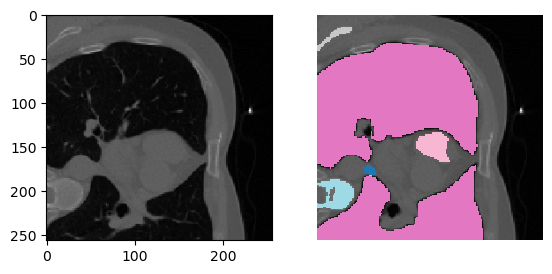

In [ ]:
plot_slice_seg(data_train[106], labels_train.iloc[106].values.reshape((256, 256)))

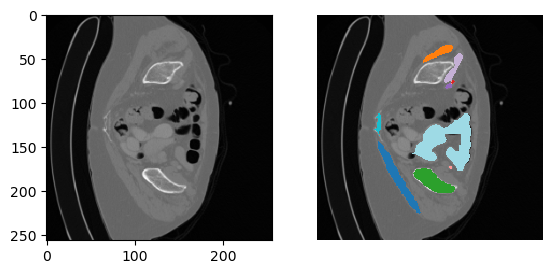

In [ ]:
plot_slice_seg(data_train[279], labels_train.iloc[279].values.reshape((256, 256)))

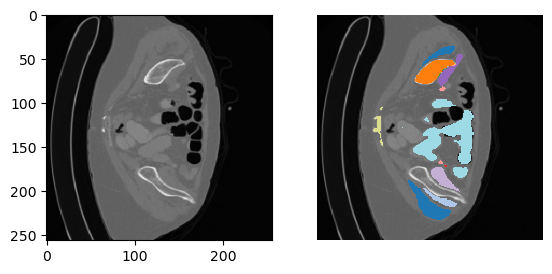

In [ ]:
plot_slice_seg(data_train[280], labels_train.iloc[280].values.reshape((256, 256)))

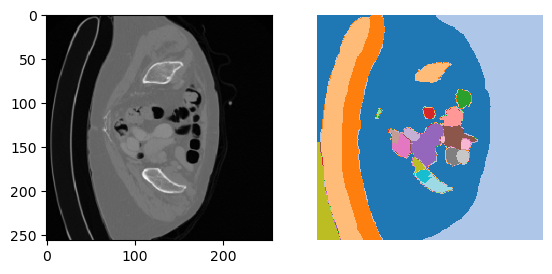

In [ ]:



# Updated baseline using Canny edge detector
def compute_baseline_one_sample(data_slice):
    # Apply Canny Edge Detector
    edges = cv2.Canny(data_slice, threshold1=10, threshold2=140)

    # Denoise and create markers
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]

    # Apply watershed
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

# Display the results
plot_slice_seg(data_train[279], compute_baseline_one_sample(data_train[279]))



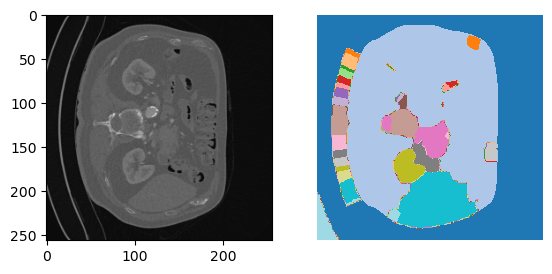

In [ ]:

# Updated baseline using Canny edge detector with preprocessing
def compute_baseline_one_sample(data_slice):
    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(data_slice, (5, 5), 1.0)

    # Apply Canny Edge Detector with adjusted thresholds
    edges = cv2.Canny(blurred, threshold1=30, threshold2=100)

    # Denoise with a larger disk and create markers
    denoised = rank.median(blurred, disk(3))
    markers = rank.gradient(denoised, disk(7)) < 15
    markers = ndi.label(markers)[0]

    # Apply watershed
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted


# Display the results
plot_slice_seg(data_train[21], compute_baseline_one_sample(data_train[21]))



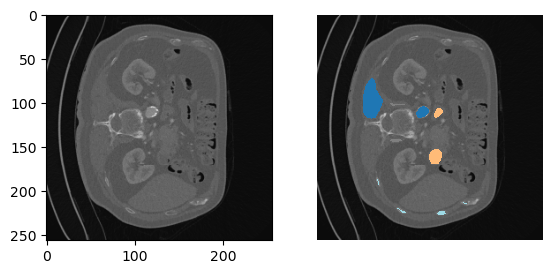

In [ ]:
plot_slice_seg(data_train[21], labels_train.iloc[21].values.reshape((256, 256)))

In [ ]:
"""# Performance Evaluation"""

def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

# Validation set
data_val = data_train[:200]
labels_val = labels_train.iloc[:200]

# Compute baseline
labels_val_predicted_baseline = compute_baseline(data_val)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.11it/s]


In [ ]:

NUM_CLASSES = 54

def dice_image(prediction, ground_truth):
    intersection = np.sum(prediction * ground_truth)
    if np.sum(prediction) == 0 and np.sum(ground_truth) == 0:
        return np.nan
    return 2 * intersection / (np.sum(prediction) + np.sum(ground_truth))

def dice_multiclass(prediction, ground_truth):
    dices = []
    for i in range(1, NUM_CLASSES + 1):
        dices.append(dice_image(prediction == i, ground_truth == i))
    return np.array(dices)

def dice_pandas(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    y_pred_df = y_pred_df.T
    y_true_df = y_true_df.T
    individual_dice = []
    for row_index in range(y_true_df.values.shape[0]):
        dices = dice_multiclass(y_true_df.values[row_index].ravel(), y_pred_df.values[row_index].ravel())
        individual_dice.append(dices)

    final = np.stack(individual_dice)
    cls_dices = np.nanmean(final, axis=0)
    return float(np.nanmean(cls_dices))

# Compute metric
dice_pandas(labels_val, labels_val_predicted_baseline)


0.001099112352664831